# Project 3 - Exponential Moving Average in Hardware

In [1]:
%matplotlib inline

import IPython
import matplotlib.pyplot as plt
import numpy as np
import math

## Quickly rebuild signals used in the previous project. 

In [2]:
time = 2.0 # plot 1 second of sample points
sample_rate =  10000# 10K samples/second
low_freq    = 100 # frequency in Hz
high_freq   = 4500 #frequency in Hz

In [3]:
x = np.linspace(0,time, int(time*sample_rate))
y1 = np.sin(2*np.pi*low_freq*x)
y1 = [int(x) for x in y1 *1000 + 1000]
y2 = np.sin(2*np.pi*high_freq*x)
y2 = [int(x) for x in y2 *1000 + 1000]
y_sum = [sum(x) for x in zip(y1, y2)]

In [4]:
#
# EMA with alpha=0.25 allows for simpler math
#
class Simple_EMA:
    def ema_all(self,buf):
        self.y=1000
        return [self.ema_1x(x) for x in buf]
    
    def ema_1x(self,x):
        #y = x * 0.25 + y * 0.75
        # y = x * 0.25 + (y * 0.25 + y * 0.50)
        self.y = int(math.floor(x/4) + math.floor(self.y/4) + math.floor(self.y/2))
        return self.y 
    
simple_ema = Simple_EMA()
sema = simple_ema.ema_all(y_sum)
sema2 = simple_ema.ema_all(sema)
sema3 = simple_ema.ema_all(sema2)

## Now it's time to map EMA to the hardware.  

(Stop here until you have generated the bitstream)

In [11]:
import pynq

class HW_EMA:
    def __init__(self, bitstream):
        overlay = pynq.Overlay(bitstream)
        self.bitflip_dma = overlay.axi_dma_0
        self.ema_1_dma = overlay.axi_dma_1
        
        self.buf_max=16

    def bitflip(self, data):
            
        input_buffer = pynq.allocate(shape=(len(data),), dtype=np.uint32)
        output_buffer = pynq.allocate(shape=(len(data),), dtype=np.uint32)
               
        # copy into our input buffer
        np.copyto(input_buffer, data, casting='unsafe')

        for s in np.arange(0,len(y_sum), self.buf_max): # here
            e = min(s + self.buf_max, len(y_sum)) # here
            
            self.bitflip_dma.sendchannel.transfer(input_buffer[s:e])
            self.bitflip_dma.recvchannel.transfer(output_buffer[s:e])
            self.bitflip_dma.sendchannel.wait()
            self.bitflip_dma.recvchannel.wait()
        
        return output_buffer
        
    def ema_1x(self, data):
        #convert to unsigned int
        data = np.array(data, dtype=np.uint32)
        
        input_buffer = pynq.allocate(shape=(len(y_sum),), dtype=np.uint32)
        output_buffer = pynq.allocate(shape=(len(y_sum),), dtype=np.uint32)
               
        # copy into our input buffer
        np.copyto(input_buffer, data)

        for s in np.arange(0,len(y_sum), self.buf_max):
            e = min(s + self.buf_max, len(y_sum))
            
            self.ema_1_dma.sendchannel.transfer(input_buffer[s:e])
            self.ema_1_dma.recvchannel.transfer(output_buffer[s:e])
            self.ema_1_dma.sendchannel.wait()
            self.ema_1_dma.recvchannel.wait()
        
        return output_buffer
    
    def ema_all(self, buf):
        #convert to unsigned int
        data = np.array(data, dtype=np.uint32)
        data = self.ema_1x(data)

        return data
        


## This is an example of using an AXI-Stream.  This block flips all the bits of the stream.  

In [12]:
hw = HW_EMA('bitstream.bit')        

buf = [0x0, 0x1, 0x2, 0x00ff00ff, 0xfffffffe, 0xffffffff]
flip_buf = hw.bitflip(buf)

print ([hex(x) for x in buf])
print ([hex(x) for x in flip_buf])

['0x0', '0x1', '0x2', '0xff00ff', '0xfffffffe', '0xffffffff']
['0xffffffff', '0xfffffffe', '0xfffffffd', '0xff00ff00', '0x1', '0x0']


## To use the ILA, first load the bitstream

In [13]:
hw = HW_EMA('bitstream.bit')        

# NOW START THE ILA 
(See Project Documentation for details)

In [14]:
# buf = [0x0, 0x1, 0x2, 0x00ff00ff, 0xfffffffe, 0xffffffff]
# flip_buf = hw.bitflip(buf)

# print ([hex(x) for x in buf])
# print ([hex(x) for x in flip_buf])

# Assignment

# This is what you need to do.  The Python code works, but you will need to generate a functioning bitstream to go with it.  

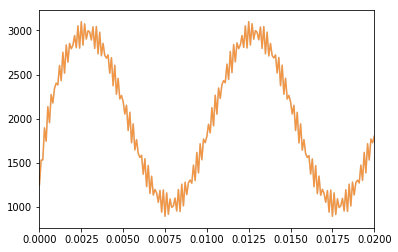

In [15]:
hw = HW_EMA('bitstream.bit')        
y_ema_hw = hw.ema_1x(y_sum)
plt.figure()
plt.plot(x,sema, alpha=0.25)
plt.plot(x,y_ema_hw, alpha=0.75)
plt.xlim((0,0.02))
plt.show()

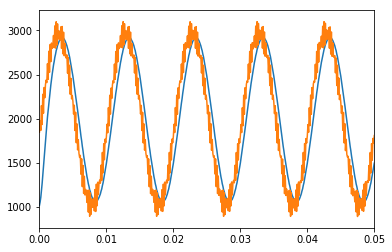

In [16]:
y_ema3_hw = hw.ema_all(y_sum)
plt.figure()
plt.plot(x,sema3)
plt.plot(x,y_ema3_hw)
plt.xlim((0,0.05))
plt.show()

IPython.display.Audio(y_ema3_hw, rate=sample_rate)

## Now we can check on runtimes

In [17]:
# a little fancyness to deal with Jupyer running as root.
import sys
import os
sys.path.insert(0,os.path.abspath('./cEMA/'))
import time
simple_ema = Simple_EMA()
import cEMA
hw = HW_EMA('bitstream.bit')        

In [18]:
stime = time.time()
a = simple_ema.ema_all(y_sum)
b = simple_ema.ema_all(a)
c = simple_ema.ema_all(b)
etime = time.time()
print("Python:  %f seconds" % (etime - stime))
py_time = etime - stime

stime = time.time()
d = cEMA.ema_all(y_sum)
e = cEMA.ema_all(d)
f = cEMA.ema_all(e)
etime = time.time()
print("C: %f seconds" % (etime - stime))
c_time = etime - stime

stime = time.time()
g = hw.ema_all(y_sum)
h = hw.ema_all(g)
i = hw.ema_all(h)
etime = time.time()
print("HW:  %f seconds" % (etime - stime))
hw_time = etime - stime


Python:  0.949069 seconds
C: 0.020884 seconds
HW:  3.405230 seconds
